<h1><center> DC GAN <br />

<h2>Preliminares: Google Colab</h2>

Para evitar limitaciones de hardware, ejecute este notebook en Google Colab con GPU. Para ello siga estos pasos:

- Suba este notebook a su cuenta de Google Drive.
- Abra el notebook. Se hará automáticamente en Google Colab.
- En el menú "Entorno de ejecución", seleccione "Cambiar tipo de entorno de ejecución" y en "Acelerador por hardware" seleccione GPU.

<h2>Preliminares: PyTorch</h2>

Por simplicidad, en esta tarea se utilizará PyTorch. Se entrega una estructura general del código a implementar, con el objetivo de no requerir conocimientos profundos del framework utilizado. Además, se entregan <i> unit tests </i> que permitirán guiar su trabajo a través de los módulos.

<h2> Deep Convolutional GAN (DCGAN) </h2>

En esta sección, usted deberá implementar una [DCGAN](https://arxiv.org/pdf/1511.06434v1.pdf), el primer modelo de GAN convolucional desarrollado en el 2015. Alguna de las características de la DCGAN son mencionadas a continuación:

*   Usa convoluciones sin capas de pooling
*   Usa BatchNormalization tanto en el Generador como en el Discriminador
*   No usa capas <i> Fully Connected </i>
*   Usa activaciones ReLU en el Generador, salvo en la última capa donde usa Tanh.
*   Usa activaciones LeakyReLU en el Discriminador, salvo en la última capa donde no usa activación

A continuación se importan los paquetes a utilizar y se define una función útil para visualizar las imágenes generadas por la GAN.

In [58]:
from IPython import display
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from StampDataset import get_SNsLoader
torch.manual_seed(0); # Set for testing purposes, please do not change!

In [59]:
# If you have multiple devices and just want to use one,
# then uncomment the following two lines:
# i_device = 1
# device = 'cuda:{0}'.format(i_device)
# Otherwise, uncomment the following line:
device = 'cuda'

In [60]:
def show_tensor_images(image_tensor, num_images=25, size=(3, 21, 21), save=False, name=None, epoch=None):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()

    # Iterate through each channel
    for channel in range(size[0]):
        channel_images = image_unflat[:, channel:channel+1, :, :]
        image_grid = make_grid(channel_images[:num_images], nrow=5)
        
        plt.figure()
        plt.imshow(image_grid.permute(1, 2, 0).squeeze(), cmap='gray')
        plt.axis('off')
        if save:
            plt.savefig('{}_channel_{}_epoch_{}.png'.format(name, channel, epoch))
        plt.show()

<h3> Bloque del Generador </h3>

Para comenzar, deberá implementar los bloques que componen el Generador.
Debido a que la función de activación varía según la capa, se deberá considerar esto al momento de la creación del bloque.

La estructura de cada bloque deberá ser la siguiente:
*   Una capa deconvolucional, utilizando los parámetros dados
*   Una capa de batchnorm, salvo en la última capa
*   Una activación ReLU después de cada batchnorm
*   Una activacion Tanh, sólo para la última capa

In [61]:
def make_gen_block(input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
    if not final_layer:
        return nn.Sequential(
            nn.ConvTranspose2d(input_channels,output_channels,kernel_size=kernel_size,stride=stride),
            nn.BatchNorm2d(output_channels),nn.ReLU()
        )
    else:
        return nn.Sequential(
            nn.ConvTranspose2d(input_channels,output_channels,kernel_size=kernel_size,stride=stride),
            nn.Tanh()
        )

In [62]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

<h2> Generador</h2>

Ahora construya un Generador formado por 4 bloques, con las siguientes especificaciones:

    1.-block: z_dim          -> hidden_dim * 4 , kernel_size=3, stride=2
    2.-block: hidden_dim * 4 -> hidden_dim * 2 , kernel_size=4, stride=1
    3.-block: hidden_dim * 2 -> hidden_dim     , kernel_size=3, stride=2
    4.-block: hidden_dim     -> im_chan        , kernel_size=4, stride=2


In [63]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            make_gen_block(self.z_dim,hidden_dim*4,kernel_size=3,stride=2),
            make_gen_block(hidden_dim*4,hidden_dim*2,kernel_size=4,stride=1),
            make_gen_block(hidden_dim*2,hidden_dim,kernel_size=3,stride=2),
            make_gen_block(hidden_dim,im_chan,kernel_size=4,stride=2,final_layer=True)
        )

    def unsqueeze_noise(self, noise):
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

<h2> Tests Generador </h2>

In [64]:
gen = Generator(im_chan=3)
num_test = 100

# Test the hidden block
test_hidden_noise = get_noise(num_test, gen.z_dim)
test_hidden_block = make_gen_block(10, 20, kernel_size=4, stride=1)
test_uns_noise = gen.unsqueeze_noise(test_hidden_noise)
hidden_output = test_hidden_block(test_uns_noise)

# Check that it works with other strides
test_hidden_block_stride = make_gen_block(20, 20, kernel_size=4, stride=2)

test_final_noise = get_noise(num_test, gen.z_dim) * 20
test_final_block = make_gen_block(10, 20, final_layer=True)
test_final_uns_noise = gen.unsqueeze_noise(test_final_noise)
final_output = test_final_block(test_final_uns_noise)

# Test the whole thing
test_gen_noise = get_noise(num_test, gen.z_dim)
test_uns_gen_noise = gen.unsqueeze_noise(test_gen_noise)
gen_output = gen(test_uns_gen_noise)
gen_output.size()

torch.Size([100, 3, 28, 28])

In [65]:
# UNIT TESTS
assert tuple(hidden_output.shape) == (num_test, 20, 4, 4)
assert hidden_output.max() > 1
assert hidden_output.min() == 0
assert hidden_output.std() < 1
assert hidden_output.std() > 0.5

assert tuple(test_hidden_block_stride(hidden_output).shape) == (num_test, 20, 10, 10)

assert final_output.max().item() == 1
assert final_output.min().item() == -1

assert tuple(gen_output.shape) == (num_test, 3, 28, 28)
assert gen_output.std() > 0.5
assert gen_output.std() < 0.8
print("Well done !")

Well done !


<h3> Bloque del discriminador</h3>

Procederemos a implementar un bloque para el discriminador.
La estructura de cada bloque deberá ser la siguiente:

*    Una capa convolucional, utilizando los parámetros dados
*    Una capa de batchnorm, excepto por la última capa
*    Una activacion LeakyReLU de pendiente 0.2, sólo después de las capas de batchnorm

In [66]:
def make_disc_block(input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels,output_channels,kernel_size=kernel_size,stride=stride),
                nn.BatchNorm2d(output_channels),nn.LeakyReLU(0.2)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels,output_channels,kernel_size=kernel_size,stride=stride)

            )

<h2> Discriminador </h2>

Ahora construya un Discriminador formado por 3 bloques, con las siguientes especificaciones:

    1.-block: im_chan        -> hidden_dim     , kernel_size=4, stride=2
    2.-block: hidden_dim     -> hidden_dim * 2 , kernel_size=4, stride=2
    3.-block: hidden_dim * 2 -> 1              , kernel_size=4, stride=2

In [67]:
class Discriminator(nn.Module):
    def __init__(self, im_chan=3, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            make_disc_block(im_chan,hidden_dim,kernel_size=4,stride=2),
            make_disc_block(hidden_dim,hidden_dim*2),
            make_disc_block(hidden_dim*2,1,final_layer=True)
        )

    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

<h2> Test Discriminador </h2>

In [68]:
num_test = 100

gen = Generator()
disc = Discriminator()
test_images = gen(get_noise(num_test, gen.z_dim))

# Test the hidden block
test_hidden_block = make_disc_block(3, 5, kernel_size=6, stride=3)
hidden_output = test_hidden_block(test_images)

# Test the final block
test_final_block = make_disc_block(3, 10, kernel_size=2, stride=5, final_layer=True)
final_output = test_final_block(test_images)

# Test the whole thing:
disc_output = disc(test_images)

In [69]:
# UNIT TESTS
# Test the hidden block
assert tuple(hidden_output.shape) == (num_test, 5, 8, 8)
assert -hidden_output.min() / hidden_output.max() > 0.15
assert -hidden_output.min() / hidden_output.max() < 0.25
assert hidden_output.std() > 0.5
assert hidden_output.std() < 1

# Test the final block
assert tuple(final_output.shape) == (num_test, 10, 6, 6)
assert final_output.max() > 1.0
assert final_output.min() < -1.0
assert final_output.std() > 0.3
assert final_output.std() < 0.6

# Test the whole thing:

assert tuple(disc_output.shape) == (num_test, 1)
assert disc_output.std() > 0.25
assert disc_output.std() < 0.5
print("Well done !")

Well done !


A continuación se definen los parámetros de entrenamiento a utlizar, y una funcion de utilidad para la inicialización de los pesos.

In [70]:
# Setting the training parameters
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
'''
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)
'''

save_dir = 'data/'
dataloader=get_SNsLoader(save_dir,batch_size=32,file_name="stamp_dataset_21_new.pkl")

In [71]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

<h3> Funciones de Loss</h3>

Implemente los métodos `get_gen_loss` y `get_disc_loss` que calculen las funciones de <i> loss </i> del modelo original de GAN, con la solución al problema de <i> vanishing gradients </i>

In [72]:
x_entropy = nn.BCEWithLogitsLoss()

def get_gen_loss(disc_fake_pred):
    ### YOUR CODE HERE ###
    label = torch.ones(disc_fake_pred.size()[0], 1).to(device)
    gen_loss =  x_entropy(disc_fake_pred.squeeze(), label.squeeze())
    return gen_loss

def get_disc_loss(disc_fake_pred, disc_real_pred):
    ### YOUR CODE HERE ###
    real_label = torch.ones(disc_real_pred.size()[0], 1).to(device)
    fake_label = torch.zeros(disc_fake_pred.size()[0], 1).to(device)
    disc_loss = x_entropy(disc_fake_pred.squeeze(),fake_label.squeeze())+ x_entropy(disc_real_pred.squeeze(),real_label.squeeze())
    return disc_loss

<h2> Entrenamiento DCGAN </h2>

A continuación se proporciona el código para el entrenamiento de la DCGAN, utilizando los métodos anteriormente implementados.

In [16]:
n_epochs = 100
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
generator_losses = []
discriminator_losses = []
for epoch in range(n_epochs):
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        # Update discriminator
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_real_pred = disc(real)
        disc_loss = get_disc_loss(disc_fake_pred, disc_real_pred)

        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        # Update generator
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = get_gen_loss(disc_fake_pred)
        gen_loss.backward()
        gen_opt.step()
        mean_generator_loss += gen_loss.item() / display_step

        # Append the losses to the lists
        discriminator_losses.append(disc_loss.item())
        generator_losses.append(gen_loss.item())

        # Visualization code
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            display.clear_output(wait=True)
            #show_tensor_images(fake, save=False, epoch=epoch, name='vanilla_dc_gan')
            #show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1


100%|██████████| 455/455 [00:02<00:00, 224.55it/s]


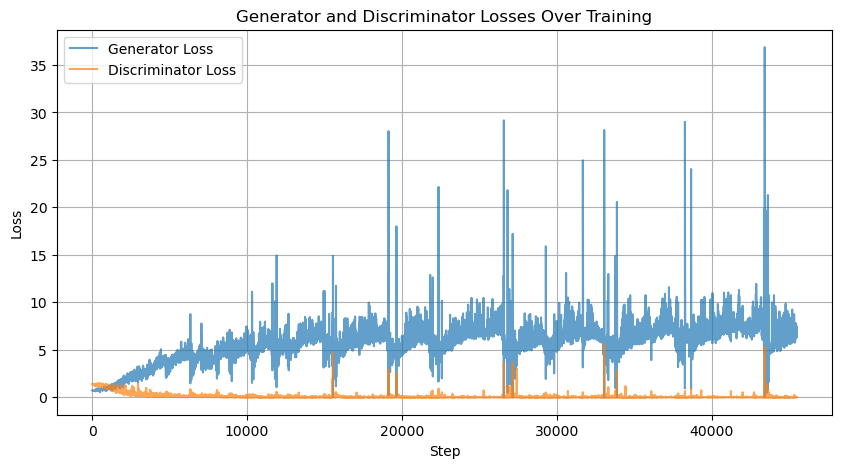

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(generator_losses, label='Generator Loss', alpha=0.7)
plt.plot(discriminator_losses, label='Discriminator Loss', alpha=0.7)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.title('Generator and Discriminator Losses Over Training')
plt.grid(True)
plt.show()

In [18]:
# Here you can either save or load a trained model
name = 'dcgan'
torch.save(gen.state_dict(), name)
# gen.load_state_dict(torch.load('dcgan'))

In [19]:
gen.load_state_dict(torch.load('dcgan'))

<All keys matched successfully>

<h2> Wasserstein GAN with Gradient Penalty (WGAN-GP) </h2>

A continuación, deberá implementar una WGAN-GP que resuelve alguno de los problemas de estabilidad en el entrenamiento de GANs. <br>En este modelo, se modifica la loss estándar por la W-loss correspondiente a una distancia de Wasserstein, y se agrega un término de penalización por gradiente que ayuda a prevenir el problema del <i>mode collapse</i>.

Debido a que los cambios del modelo son hechos a la loss, es posible utilizar el mismo Generador y Discriminador de la DCGAN. <br>En esta ocasión, el discriminador pasará a llamarse crítico, por su función de entregar valores reales a cada uno de los ejemplos presentados, en vez de clasificarlos como real/falso.

Comenzaremos por definir una función de utilidad para poder hacer seguimiento de los valores del gradiente, e inicializar nuevamente los pesos.

In [73]:
def make_grad_hook():
    grads = []
    def grad_hook(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            grads.append(m.weight.grad)
    return grads, grad_hook

In [75]:
# New training parameters
n_epochs = 300
display_step = 50
c_lambda = 10
crit_repeats = 5

In [76]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
crit = Discriminator().to(device)
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(beta_1, beta_2))

gen = gen.apply(weights_init)
crit = crit.apply(weights_init)

## Gradient Penalty

La loss del discriminador requerirá de un término adicional de penalización.
Este corresponde a
$ \displaystyle \mathop{\mathbb{E }}_{\hat{\mathbf{x}}}[ (\lVert \nabla_{\hat{\mathbf{x}}} D(\hat{\mathbf{x}}) \rVert - 1)^2 ]$

Para su cálculo, usted deberá:
   - Calcular $\hat{x}$, un promedio ponderado entre imágenes reales y falsas: $\hat{\mathbf{x}} = \epsilon \mathbf{x} + (1-\epsilon)G(\mathbf{z})$, siendo $\epsilon$ escogido aleatoriamente entre 0 y 1
   - Calcular el <i> score </i> entregado por el crítico a $\hat{x}$
   - Calcular el gradiente.
   - Computar el término de gradient penalty.

In [77]:
def get_gradient(crit_model, real_images, fake_images, epsilon):

    ### YOUR CODE HERE ###
    mixed_images = epsilon*real_images + (1-epsilon)*fake_images
    mixed_scores = crit_model(mixed_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        ### YOUR CODE HERE ###
        inputs=mixed_images,
        outputs=mixed_scores,
        # These other parameters have to do with how the pytorch autograd engine works
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    return gradient


In [78]:
def test_get_gradient(image_shape):
    real = torch.randn(*image_shape, device=device) + 1
    fake = torch.randn(*image_shape, device=device) - 1
    epsilon_shape = [1 for _ in image_shape]
    epsilon_shape[0] = image_shape[0]
    epsilon = torch.rand(epsilon_shape, device=device).requires_grad_()
    gradient = get_gradient(crit, real, fake, epsilon)
    assert tuple(gradient.shape) == image_shape
    assert gradient.max() > 0
    assert gradient.min() < 0
    return gradient

gradient = test_get_gradient((256, 3, 28, 28))
print("Well done !")

Well done !


Ahora, implemente el método `gradient_penalty` para calcular el término completo de penalización de gradiente, dado los gradientes

*    No olvide computar la esperanza


In [79]:
def gradient_penalty(gradient):

    gradient = gradient.view(len(gradient), -1)

    ### YOUR CODE HERE ###
    # Calculate the magnitude of every row
    gradient_norm = torch.pow(torch.norm(gradient,dim = 1)-1,2)

    # Penalize the mean squared distance of the gradient norms from 1
    penalty = torch.mean(gradient_norm)
    return penalty

In [80]:
# UNIT TEST
def test_gradient_penalty(image_shape):
    bad_gradient = torch.zeros(*image_shape)
    bad_gradient_penalty = gradient_penalty(bad_gradient)
    assert torch.isclose(bad_gradient_penalty, torch.tensor(1.))

    image_size = torch.prod(torch.Tensor(image_shape[1:]))
    good_gradient = torch.ones(*image_shape) / torch.sqrt(image_size)
    good_gradient_penalty = gradient_penalty(good_gradient)
    assert torch.isclose(good_gradient_penalty, torch.tensor(0.))

    random_gradient = test_get_gradient(image_shape)
    random_gradient_penalty = gradient_penalty(random_gradient)
    assert torch.abs(random_gradient_penalty - 1) < 0.1

test_gradient_penalty((256, 3, 28, 28))
print("Well done !")

Well done !


## Losses

En una WGAN-GP, el discriminador se utiliza para aproximar la distancia de Wasserstein, la cual está dada por la expresión:  

$\mathbb{W} \approx \displaystyle \mathop{\mathbb{E }}_{{\mathbf{x}}}[D(\mathbf{x})] - \displaystyle \mathop{\mathbb{E }}_{\mathbf{x}'=G(\mathbf{z})} [D(G(\mathbf{z}))] + \displaystyle \mathop{\mathbb{E }}_{\hat{\mathbf{x}}} \lambda (\lVert \nabla_{\hat{\mathbf{x}}} D(\hat{\mathbf{x}}) \rVert - 1)^2 $

Usted deberá implementar los métodos `get_gen_wloss` y `get_crit_wloss` que devuelvan $L_{D}$ y $L_{G}$, los cuales serán utilizados para maximizar y minimizar $\mathbb{W}$, respectivamente.

Obs: Notar que $L_G$ sólo debería tener un término

In [81]:
def get_gen_wloss(crit_fake_pred):
    ### YOUR CODE HERE ###
    gen_loss = -torch.mean(crit_fake_pred)
    return gen_loss

In [82]:
# UNIT TEST
assert torch.isclose(
    get_gen_wloss(torch.tensor(1.)), torch.tensor(-1.0)
)

assert torch.isclose(
    get_gen_wloss(torch.rand(10000)), torch.tensor(-0.5), 0.05
)

print("Well done !")

Well done !


In [83]:
def get_crit_wloss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    ### YOUR CODE HERE ###
    loss_1 = torch.mean(crit_real_pred)
    loss_2 = c_lambda * gp
    loss_3 = get_gen_wloss(crit_fake_pred)
    crit_loss = loss_1 - loss_2 + loss_3
    return -crit_loss

In [84]:
# UNIT TEST
assert torch.isclose(
    get_crit_wloss(torch.tensor(1.), torch.tensor(2.), torch.tensor(3.), 0.1),
    torch.tensor(-0.7)
)
assert torch.isclose(
    get_crit_wloss(torch.tensor(20.), torch.tensor(-20.), torch.tensor(2.), 10),
    torch.tensor(60.)
)

print("Well done !")

Well done !


## Entrenamiento WGAN-GP

Usted notará que, aún corriendo en GPU, el entrenamiento será notoriamente más lento. ¿Por qué? <br>
<font size=3 color=red> <b>Respuesta: </b></font>

Step 45450: Generator loss: 7.252504596710205, critic loss: 0.03655330848693847


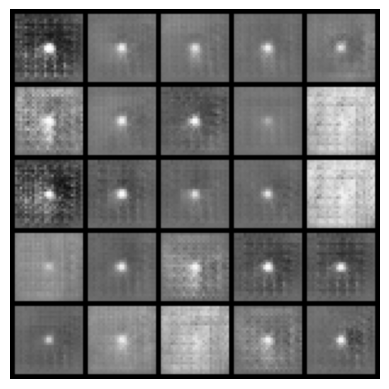

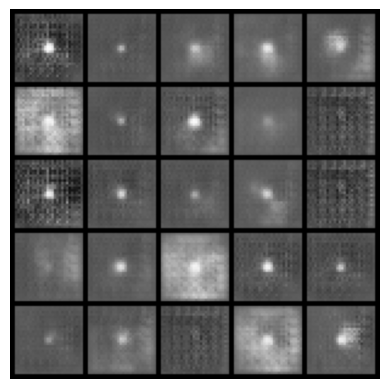

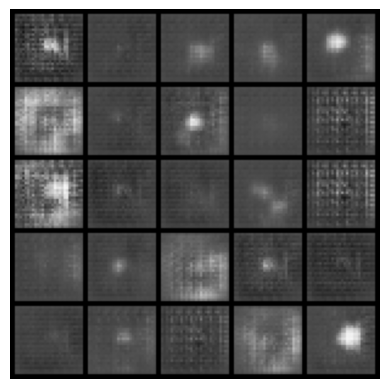

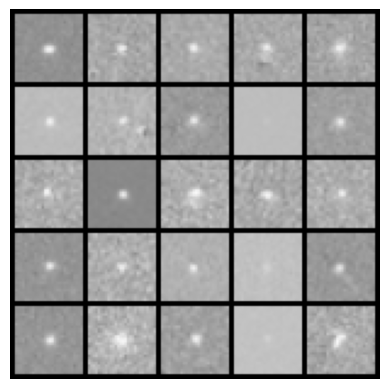

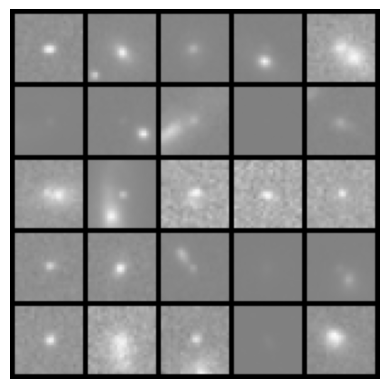

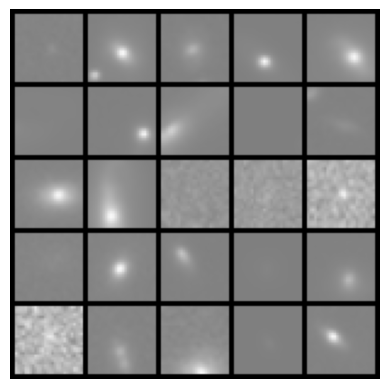

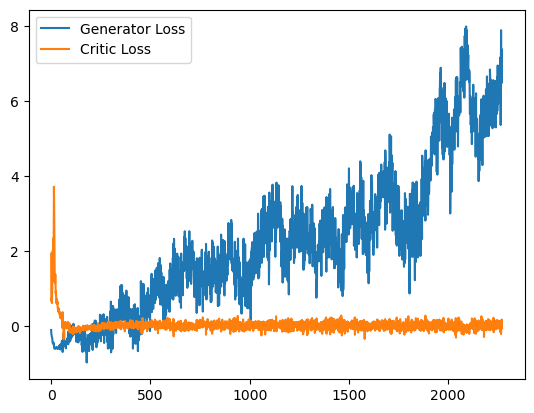

100%|██████████| 455/455 [00:14<00:00, 31.15it/s]


In [31]:
cur_step = 0
generator_losses = []
critic_losses = []
for epoch in range(n_epochs):
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        mean_iteration_critic_loss = 0
        for _ in range(crit_repeats):
            # Update critic
            crit_opt.zero_grad()
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            crit_fake_pred = crit(fake.detach())
            crit_real_pred = crit(real)

            epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(crit, real, fake.detach(), epsilon)
            gp = gradient_penalty(gradient)
            crit_loss = get_crit_wloss(crit_fake_pred, crit_real_pred, gp, c_lambda)

            mean_iteration_critic_loss += crit_loss.item() / crit_repeats
            # Update gradients
            crit_loss.backward(retain_graph=True)
            # Update optimizer
            crit_opt.step()
        critic_losses += [mean_iteration_critic_loss]

        # Update generator
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        crit_fake_pred = crit(fake_2)

        gen_loss = get_gen_wloss(crit_fake_pred)
        gen_loss.backward()

        # Update the weights
        gen_opt.step()

        generator_losses += [gen_loss.item()]

        # Visualization code
        if cur_step % display_step == 0 and cur_step > 0:
            display.clear_output(wait=True)
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            crit_mean = sum(critic_losses[-display_step:]) / display_step
            print(f"Step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")
            show_tensor_images(fake, save=False, name='wgangp')
            show_tensor_images(real)
            step_bins = 20
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Critic Loss"
            )
            plt.legend()
            plt.show()

        cur_step += 1

In [32]:
# Here you can either save or load a trained model
name = 'wgangp'
torch.save(gen.state_dict(), name)
#gen.load_state_dict(torch.load(name)

<h2> Evaluación : Fréchet Inception Distance </h2>

In [33]:
!pip install wget

In [34]:
import wget
import os
import seaborn as sns

filename = 'inception_v3_google-1a9a5a14.pth'
url = 'https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth'

if not os.path.exists(filename):
    wget.download(url)

In [35]:
from torchvision.models import inception_v3

# This may take a while
inception_model = inception_v3(pretrained=False)
inception_model.load_state_dict(torch.load(filename))
inception_model.to(device)
inception_model = inception_model.eval() # Evaluation mode

/home/nfierroflo/anaconda3/envs/gans/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nfierroflo/anaconda3/envs/gans/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/nfierroflo/anaconda3/envs/gans/lib/python3.11/site-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


**Formula**

Basado en el paper "[The Fréchet distance between multivariate normal distributions](https://core.ac.uk/reader/82269844)" la distancia de Fréchet entre dos distribuciones gaussianas multivariadas $X$ and $Y$ es:

$d(X, Y) = \Vert\mu_X-\mu_Y\Vert^2 + \mathrm{Tr}\left(\Sigma_X+\Sigma_Y - 2 \sqrt{\Sigma_X \Sigma_Y}\right)$


Ahora usted deberá implementarla.

Obs:

*   Le podrían ser de utilidad las funciones `torch.norm` y `torch.trace`.
*   Se le proporciona una función `matrix_sqrt()` -- usela en vez de `torch.sqrt()` que entrega la raíz cuadrada elemento por elemento.
</details>

In [36]:
import scipy

def matrix_sqrt(x):
    y = x.cpu().detach().numpy()
    y = scipy.linalg.sqrtm(y)
    return torch.Tensor(y.real, device=x.device)

In [37]:
def frechet_distance(mu_x, mu_y, sigma_x, sigma_y):
    first = torch.norm(mu_x-mu_y)
    second = sigma_x+sigma_y - 2* matrix_sqrt(torch.matmul(sigma_x,sigma_y))
    fd = torch.pow(first,2) + torch.trace(second)
    #### START CODE HERE ####
    return fd

In [38]:
# UNIT TESTS

from torch.distributions import MultivariateNormal

mean1 = torch.Tensor([0, 0])
covariance1 = torch.Tensor(
    [[1, 0],
     [0, 1]]
)
dist1 = MultivariateNormal(mean1, covariance1)

mean2 = torch.Tensor([0, 0])
covariance2 = torch.Tensor(
    [[2, -1],
     [-1, 2]]
)
dist2 = MultivariateNormal(mean2, covariance2)

assert torch.isclose(frechet_distance(dist1.mean, dist2.mean,dist1.covariance_matrix, dist2.covariance_matrix),4 - 2 * torch.sqrt(torch.tensor(3.)))

assert (frechet_distance(
        dist1.mean, dist1.mean,
        dist1.covariance_matrix, dist1.covariance_matrix
    ).item() == 0)

print("Well done !")

Well done !


In [39]:
scipy.__version__

'1.11.1'

# Para usar la función `frechet_distance`, se proporciona el método `get_covariance` el cual entrega la matriz de covarianza a partir de una lista de features.

In [40]:
import numpy as np

def get_covariance(features):
    return torch.Tensor(np.cov(features.detach().numpy(), rowvar=False))

Finalmente, usted utilizará el modelo Inception-v3 pre-entrenado para calcular los features en imágenes reales y generadas, para luego obtener la métrica de FID de los dos modelos entrenados con anterioridad. A continuación se entrega un código para hacer el calculo de features sobre los ejemplos reales y generados.

In [41]:
torch.cuda.empty_cache()

In [42]:
gen.eval()
n_samples = 5000 # The total number of samples
batch_size = 1 # Samples per iteration

#dataloader = DataLoader(MNIST('.', download=False, transform=transform),
#                       batch_size=batch_size,
#                        shuffle=True)

dataloader=get_SNsLoader(save_dir,batch_size=batch_size,file_name="stamp_dataset_21_new.pkl")

def preprocess(img):
    # Ensure that the input has 3 channels (assuming grayscale input)
    if img.size(1) == 1:
        img = img.repeat(1, 3, 1, 1)
    img = torch.nn.functional.interpolate(img, size=(299, 299), mode='bilinear', align_corners=False)
    return img

def compute_features(gen, dataloader=dataloader, n_samples=5000, z_dim = 64, inception_model=inception_model, device='cuda'):
    fake_features_list = []
    real_features_list = []
    cur_samples = 0

    with torch.no_grad():
        for real_example, _ in tqdm(dataloader, total=len(dataloader)):
            real_samples = preprocess(real_example)
            real_features = inception_model(real_samples.to(device)).detach().to('cpu')
            real_features_list.append(real_features)

            fake_samples = get_noise(len(real_example), z_dim).to(device)
            fake_samples = preprocess(gen(fake_samples))
            fake_features = inception_model(fake_samples.to(device)).detach().to('cpu')
            fake_features_list.append(fake_features)
            cur_samples += len(real_example)

            if cur_samples >= n_samples:
                break

    return real_features_list, fake_features_list


In [43]:
# Load the desired generator
# gen = None
gen_1 = Generator(z_dim).to(device)
gen_1.load_state_dict(torch.load('dcgan'))
gen = Generator(z_dim).to(device)
gen.load_state_dict(torch.load('wgangp'))
fake_features_list_2, real_features_list_2 = compute_features(gen_1)
fake_features_list, real_features_list = compute_features(gen)

 34%|███▍      | 4999/14542 [01:20<02:33, 62.27it/s]


Utilizando el código anterior, calcule el FID de los modelos DCGAN y WGAN-GP. Para esto:
*     Junte los features calculados en el bloque anterior en un tensor
*     Calcule los estadísticos necesarios
*     Utilice la función `frechet_distance` anteriormente implementada, utilizando los estadísticos previamente calculados

In [44]:
### YOUR CODE HERE ###
fake_features_all = torch.reshape(torch.stack(fake_features_list),(5000,1000))
real_features_all = torch.reshape(torch.stack(real_features_list),(5000,1000))

mu_fake = torch.mean(fake_features_all,0)
mu_real = torch.mean(real_features_all,0)
sigma_fake = get_covariance(fake_features_all)
sigma_real = get_covariance(real_features_all)

In [45]:
fake_features_all_1 = torch.reshape(torch.stack(fake_features_list_2),(5000,1000))
real_features_all_1 = torch.reshape(torch.stack(real_features_list_2),(5000,1000))

mu_fake_1 = torch.mean(fake_features_all_1,0)
mu_real_1 = torch.mean(real_features_all_1,0)
sigma_fake_1 = get_covariance(fake_features_all_1)
sigma_real_1 = get_covariance(real_features_all_1)

In [46]:
with torch.no_grad():
    print('WGAN-GP',frechet_distance(mu_real, mu_fake, sigma_real, sigma_fake).item())
    print('DCGAN',frechet_distance(mu_real_1, mu_fake_1, sigma_real_1, sigma_fake_1).item())

WGAN-GP 904.7725219726562
DCGAN 1199.90869140625


In [47]:
print("test")

test


# Experimentos sin features solo con imágenes

In [48]:
import torch
void_tensor=torch.tensor([1,2])

In [49]:
#check if a tensor is empty
if void_tensor.nelement() != 0:
    print("has elements")
else:
    print("is empty")

has elements


In [50]:
gen_1 = Generator(z_dim).to(device)
gen_1.load_state_dict(torch.load('dcgan'))
gen = Generator(z_dim).to(device)
gen.load_state_dict(torch.load('wgangp'))
num_img=500
fake_noise = get_noise(num_img, z_dim, device=device)
fake_1 = gen_1(fake_noise)
fake= gen(fake_noise)

In [51]:
fake_1.shape

torch.Size([500, 3, 28, 28])

In [52]:
import pickle as pk
save_dir = 'data/'

with open(save_dir + "stamp_dataset_only_images_63.pkl", "rb") as f:
    data = pk.load(f)
Train_dict = data['Train']
Validation_dict = data['Validation']
train_images = Train_dict['images']
validation_images = Validation_dict['images']
labels_train = Train_dict['class']
labels_val = Validation_dict['class']

In [53]:
from collections import Counter
import numpy as np

class_counter = Counter(labels_train)
print('Class distribution in the training dataset:', class_counter)

data['Train']['images'].shape


Class distribution in the training dataset: Counter({'AGN': 14542, 'VS': 14523, 'bogus': 10534, 'asteroid': 9599, 'SN': 1396})


(50594, 63, 63, 3)

In [54]:
# Define a mapping from string classes to numerical labels
class_to_label = {
    'AGN': 0,
    'SN': 1,
    'VS': 2,
    'asteroid': 3,
    'bogus': 4
}

# Create a custom transformation function to map string classes to numerical labels
def map_class_to_label(class_name):
    return class_to_label.get(class_name, -1)  # -1 for unknown classes

numerical_labels = [map_class_to_label(class_name) for class_name in labels_train]

In [55]:
numerical_labels
from collections import Counter
import numpy as np

class_counter = Counter(numerical_labels)
print('Class distribution in the training dataset:', class_counter)

Class distribution in the training dataset: Counter({0: 14542, 2: 14523, 4: 10534, 3: 9599, 1: 1396})


In [56]:
train_images = Train_dict['images'][:, 14:42, 14:42, :]

In [57]:
train_images.shape

(50594, 28, 28, 3)